4 labels:
- EOSINOPHIL
- LYMPHOCYTE
- MONOCYTE
- NEUTROPHIL


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

%matplotlib inline

In [2]:
data_dir = "blood_cell_data"

In [3]:
train_data_dir = os.path.join(data_dir, "TRAIN")
validation_data_dir = os.path.join(data_dir, "TEST")
print(train_data_dir)

blood_cell_data\TRAIN


In [4]:
# Count images
import glob

for i in os.listdir(train_data_dir):
    print(i, len(glob.glob(train_data_dir + "/" + i + "/*")))

EOSINOPHIL 2497
LYMPHOCYTE 2483
MONOCYTE 2478
NEUTROPHIL 2499


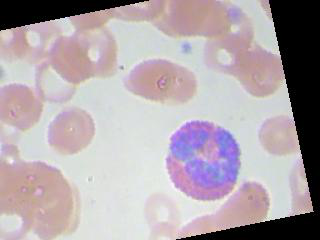

In [5]:
import pathlib

train_data_dir = pathlib.Path(train_data_dir)

EOSINOPHIL = list(train_data_dir.glob('EOSINOPHIL/*'))
PIL.Image.open(str(EOSINOPHIL[1]))

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9957 files belonging to 4 classes.
Using 7966 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9957 files belonging to 4 classes.
Using 1991 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


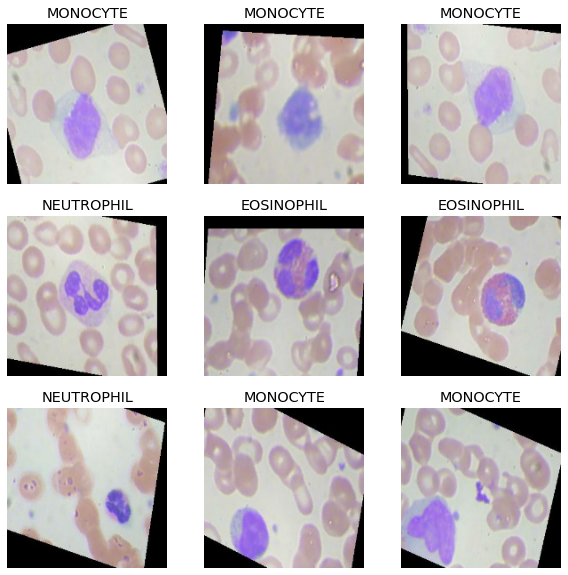

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [56]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [57]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [58]:
normalization_layer = layers.Rescaling(1./255)

In [59]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.98445946


In [1]:
## Create the model

num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(24, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

NameError: name 'class_names' is not defined

In [2]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

NameError: name 'model' is not defined

In [62]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_6 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 8)       224       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 8)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 16)        1168      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 45, 45, 24)        3480      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 22, 22, 24)       

In [63]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
249/249 [==============================] - 49s 197ms/step - loss: 1.2309 - accuracy: 0.4146 - val_loss: 1.0362 - val_accuracy: 0.5319
Epoch 2/50
249/249 [==============================] - 44s 178ms/step - loss: 0.9538 - accuracy: 0.5808 - val_loss: 0.8904 - val_accuracy: 0.6243
Epoch 3/50
249/249 [==============================] - 44s 176ms/step - loss: 0.7283 - accuracy: 0.6847 - val_loss: 0.6943 - val_accuracy: 0.7132
Epoch 4/50
249/249 [==============================] - 43s 172ms/step - loss: 0.4937 - accuracy: 0.7910 - val_loss: 0.5718 - val_accuracy: 0.7489
Epoch 5/50
249/249 [==============================] - 57s 229ms/step - loss: 0.3512 - accuracy: 0.8569 - val_loss: 0.5198 - val_accuracy: 0.7865
Epoch 6/50
249/249 [==============================] - 50s 202ms/step - loss: 0.2555 - accuracy: 0.9036 - val_loss: 0.5828 - val_accuracy: 0.7805
Epoch 7/50
249/249 [==============================] - 46s 183ms/step - loss: 0.1736 - accuracy: 0.9355 - val_loss: 0.5680 - val_ac

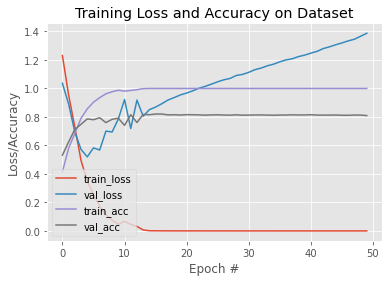

In [64]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [65]:
history.history["val_accuracy"] # 14th epoch is the best

[0.5318934917449951,
 0.6243094205856323,
 0.7132094502449036,
 0.7488698959350586,
 0.7865394353866577,
 0.7805123329162598,
 0.794575572013855,
 0.760421872138977,
 0.7835258841514587,
 0.7910597920417786,
 0.7408337593078613,
 0.8156704902648926,
 0.7609241604804993,
 0.8176795840263367,
 0.8156704902648926,
 0.8206931352615356,
 0.8206931352615356,
 0.8146659731864929,
 0.8156704902648926,
 0.8136614561080933,
 0.8161727786064148,
 0.8156704902648926,
 0.8146659731864929,
 0.8126569390296936,
 0.8146659731864929,
 0.8151682615280151,
 0.8136614561080933,
 0.8126569390296936,
 0.8151682615280151,
 0.8126569390296936,
 0.8131592273712158,
 0.8141637444496155,
 0.8141637444496155,
 0.8131592273712158,
 0.8121547102928162,
 0.8136614561080933,
 0.8136614561080933,
 0.8151682615280151,
 0.8141637444496155,
 0.8141637444496155,
 0.8156704902648926,
 0.8131592273712158,
 0.8131592273712158,
 0.8131592273712158,
 0.8136614561080933,
 0.8121547102928162,
 0.811652421951294,
 0.8136614561080

# With Full Dataset

In [24]:
train_data_dir = os.path.join(data_dir, "TRAIN")
validation_data_dir = os.path.join(data_dir, "TEST")
print(validation_data_dir)

blood_cell_data\TEST


In [26]:
# Count images
import glob

for i in os.listdir(validation_data_dir):
    print(i, len(glob.glob(validation_data_dir + "/" + i + "/*")))

EOSINOPHIL 13
LYMPHOCYTE 6
MONOCYTE 4
NEUTROPHIL 48


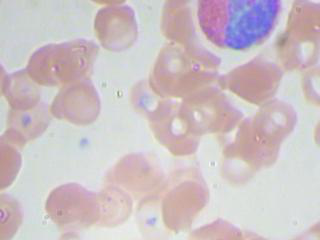

In [27]:
import pathlib

train_data_dir = pathlib.Path(train_data_dir)
validation_data_dir = pathlib.Path(validation_data_dir)

EOSINOPHIL = list(validation_data_dir.glob('EOSINOPHIL/*'))
PIL.Image.open(str(EOSINOPHIL[1]))

In [28]:
batch_size = 32
img_height = 180
img_width = 180

In [31]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9957 files belonging to 4 classes.


In [33]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  validation_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 71 files belonging to 4 classes.


In [34]:
class_names = train_ds.class_names
print(class_names)

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


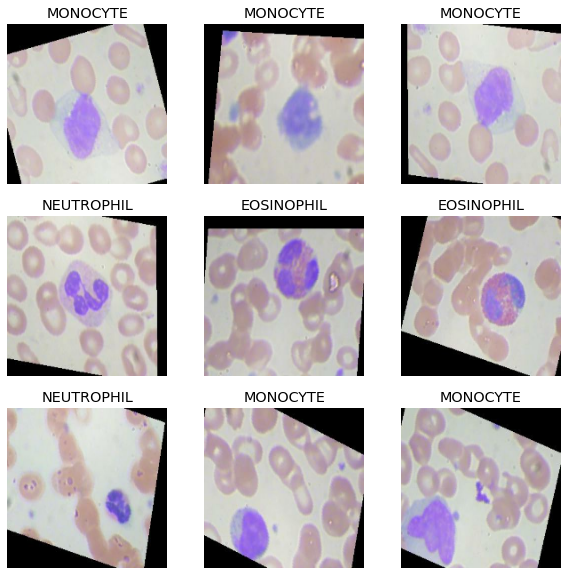

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [36]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [37]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [38]:
normalization_layer = layers.Rescaling(1./255)

In [39]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9781046


In [40]:
## Create the model

num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(24, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [41]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 8)       224       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 16)        1168      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 24)        3480      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 22, 24)       

In [43]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
312/312 [==============================] - 76s 240ms/step - loss: 1.2122 - accuracy: 0.4119 - val_loss: 1.1937 - val_accuracy: 0.3944
Epoch 2/10
312/312 [==============================] - 70s 224ms/step - loss: 0.8005 - accuracy: 0.6425 - val_loss: 1.0993 - val_accuracy: 0.3944
Epoch 3/10
312/312 [==============================] - 73s 234ms/step - loss: 0.4652 - accuracy: 0.7881 - val_loss: 0.6799 - val_accuracy: 0.6197
Epoch 4/10
312/312 [==============================] - 59s 189ms/step - loss: 0.3242 - accuracy: 0.8633 - val_loss: 0.7548 - val_accuracy: 0.5775
Epoch 5/10
312/312 [==============================] - 67s 214ms/step - loss: 0.2102 - accuracy: 0.9154 - val_loss: 0.6548 - val_accuracy: 0.6761
Epoch 6/10
312/312 [==============================] - 69s 221ms/step - loss: 0.1401 - accuracy: 0.9471 - val_loss: 0.8510 - val_accuracy: 0.6479
Epoch 7/10
312/312 [==============================] - 78s 251ms/step - loss: 0.0939 - accuracy: 0.9658 - val_loss: 0.7220 - val_ac

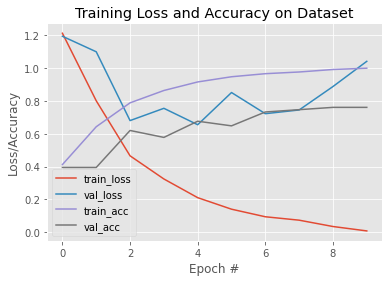

In [45]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")